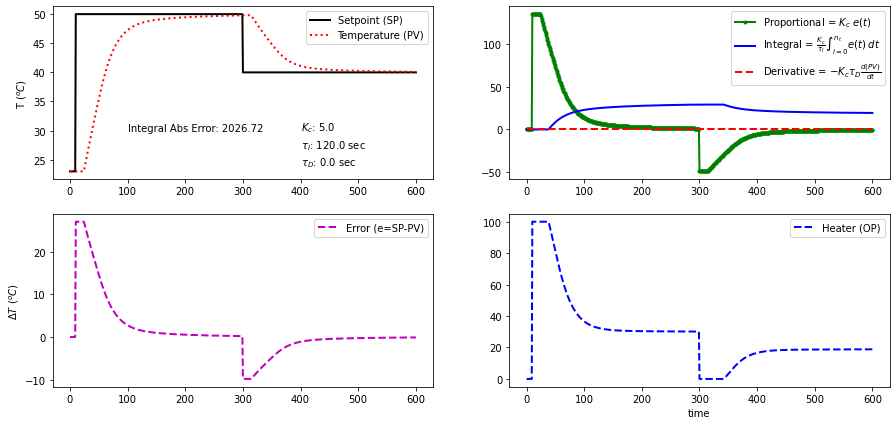

PID Simulator: Adjust Kc, tauI, and tauD to achieve lowest Integral Abs Error


In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display

n = 601 # time points to plot
tf = 600.0 # final time

# TCLab FOPDT
Kp = 0.9
taup = 175.0
thetap = 15.0

def process(y,t,u):
    dydt = (1.0/taup) * (-(y-23.0) + Kp * u)
    return dydt

def pidPlot(Kc,tauI,tauD):
    t = np.linspace(0,tf,n) # create time vector
    P = np.zeros(n)          # initialize proportional term
    I = np.zeros(n)         # initialize integral term
    D = np.zeros(n)         # initialize derivative term
    e = np.zeros(n)         # initialize error
    OP = np.zeros(n)        # initialize controller output
    PV = np.ones(n)*23.0    # initialize process variable
    SP = np.ones(n)*23.0    # initialize setpoint
    SP[10:300] = 50.0       # step up
    SP[300:601] = 40.0      # step down    
    y0 = 23.0               # initial condition
    iae = 0.0
    # loop through all time steps
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        y = odeint(process,y0,ts,args=(OP[max(0,i-int(thetap))],))
        y0 = y[1]                  # record new initial condition
        iae += np.abs(SP[i]-y0[0])
        # calculate new OP with PID
        PV[i] = y[1]               # record PV
        e[i] = SP[i] - PV[i]       # calculate error = SP - PV
        dt = t[i] - t[i-1]         # calculate time step
        P[i] = Kc * e[i]           # calculate proportional term
        I[i] = I[i-1] + (Kc/tauI) * e[i] * dt  # calculate integral term
        D[i] = -Kc * tauD * (PV[i]-PV[i-1])/dt # calculate derivative term
        OP[i] = P[i] + I[i] + D[i] # calculate new controller output
        if OP[i]>=100:
            OP[i] = 100.0
            I[i] = I[i-1] # reset integral
        if OP[i]<=0:
            OP[i] = 0.0
            I[i] = I[i-1] # reset integral            

    # plot PID response
    plt.figure(1,figsize=(15,7))
    plt.subplot(2,2,1)
    plt.plot(t,SP,'k-',linewidth=2,label='Setpoint (SP)')
    plt.plot(t,PV,'r:',linewidth=2,label='Temperature (PV)')
    plt.ylabel(r'T $(^oC)$')
    plt.text(100,30,'Integral Abs Error: ' + str(np.round(iae,2)))
    plt.text(400,30,r'$K_c$: ' + str(np.round(Kc,0)))  
    plt.text(400,27,r'$\tau_I$: ' + str(np.round(tauI,0)) + ' sec')  
    plt.text(400,24,r'$\tau_D$: ' + str(np.round(tauD,0)) + ' sec')  
    plt.legend(loc='best')
    plt.subplot(2,2,2)
    plt.plot(t,P,'g.-',linewidth=2,label=r'Proportional = $K_c \; e(t)$')
    plt.plot(t,I,'b-',linewidth=2,label=r'Integral = ' + \
             r'$\frac{K_c}{\tau_I} \int_{i=0}^{n_t} e(t) \; dt $')
    plt.plot(t,D,'r--',linewidth=2,label=r'Derivative = ' + \
             r'$-K_c \tau_D \frac{d(PV)}{dt}$')  
    plt.legend(loc='best')
    plt.subplot(2,2,3)
    plt.plot(t,e,'m--',linewidth=2,label='Error (e=SP-PV)')
    plt.ylabel(r'$\Delta T$ $(^oC)$')
    plt.legend(loc='best')
    plt.subplot(2,2,4)
    plt.plot(t,OP,'b--',linewidth=2,label='Heater (OP)')
    plt.legend(loc='best')
    plt.xlabel('time')

Kc_slide = wg.FloatSlider(value=5.0,min=0.0,max=50.0,step=1.0)
tauI_slide = wg.FloatSlider(value=120.0,min=20.0,max=180.0,step=5.0)
tauD_slide = wg.FloatSlider(value=0.0,min=0.0,max=20.0,step=1.0)
wg.interact(pidPlot, Kc=Kc_slide, tauI=tauI_slide, tauD=tauD_slide)
print('PID Simulator: Adjust Kc, tauI, and tauD to achieve lowest Integral Abs Error')